<h2> Capstone project: The Battle of Neighborhoods (week 2) </h2>
<h3> Business Prospect and Venues Data Analysis in Bali, Indonesia </h3> by: <b>Nur Cahyo Nugroho </b>

<img src="https://media.timeout.com/images/105240189/image.jpg" width="500" height="600">

<h3>1. Introduction</h3>
<p>Bali is one of main Indonesia's tourism destination, which has seen a significant rise in tourists since the 1980s. Tourism-related business makes up 80% of its economy. It is renowned for its highly developed arts, including traditional and modern dance, sculpture, painting, leather, metalworking, and music. There's so much business opportunity in this island, with potential customer from both local residents and the tourists. </p>
<p>Business people will need to perform research and exploration of the neighborhood before open any business in specific location to understand many factors, like nearby residential area, tourist place & office, another similar competitor, public facilities, and most importantly average rental fare.</p>

<h3>2. Objective</h3>
<p>This project will give insight to business people to comparing neighborhoods based on districts in Bali to choose best suited location based on top 10 common venues surrounding it.</p>
<p>Methods:
<ul>
    <li>Web scraping the list of district/kecamatan in Bali from Wikipedia.</li>
    <li>Extracting top trending venues using Foursquare API. </li>
    <li>Forming neighborhood clusters based on venue categories using unsupervised <i>k-means</i> clustering algorithm. </li>
    <li>Understanding the similarities and differences between district to retrieve more insights and to conclude which neighborhood is best suited for business prospect. </li>
</ul></p>

<h3>3. Data Reference and Library</h3>
<h4>3.1. District list in Bali</h4>
I will be extracting list of districts in Bali from Wikipedia page: <a href="url">https://en.wikipedia.org/wiki/Bali</a>. 
Using read_html() to extract HTML table information from Wikipedia, and Panda libraries to load it into dataframe and perform necessary data clean-up. 
<h4>3.2. Geolocation of each district in Bali</h4>
Geolocation contains longtitude and latitude of each district in Bali from csv file that I will upload in GitHub. Using panda dataframe to load the data and merge it with above district information, then get top venues using Foursquare API using geolocation information.
<h4>3.3. Library </h4>
<ul>
    <li>Panda libraries for dataframe and other dataset manipulation.</li>
    <li>Numpy for any scientific computation.</li>
    <li>Requests to call Foursquare API.</li>
    <li>KMeans cluster from sklearn for clustering.</li>
    <li>Matplotlib for plotting modules.</li>
    <li>Folium for map plotting.</li>
</ul>  

<h3>4. Python Notebook</h3>
<h4>4.1. Download and extract dataset</h4>

Import all necessary libraries:

In [193]:
import pandas as pd
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# we are using the inline backend
%matplotlib inline 

#seaborn for plotting
import seaborn as sns

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

import folium # plotting library

from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


Read data from Wikipedia and convert it to panda dataframe:

In [169]:
#Call from webpage url and store them as dataframes in an array, each element is a dataframe
wiki_tables = pd.read_html("https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali", header=0) 

#Convert to dataframe
bali_raw_df = wiki_tables[0]
bali_raw_df.head(10)
#Bali_raw_df.dtypes

#Create new dataframe, get 'Kabupaten/Kota' and 'Jumlah penduduk (2017)' as 'District' and 'Total Population'
bali_df = bali_raw_df[['Kabupaten/kota', 'Jumlah penduduk (2017)[1]']]
bali_df.rename(columns={'Kabupaten/kota':'District', 'Jumlah penduduk (2017)[1]':'Population'}, inplace=True)
bali_df

,District,Population
0,Kabupaten Badung,468.346
1,Kabupaten Bangli,264.945
2,Kabupaten Buleleng,814.356
3,Kabupaten Gianyar,492.757
4,Kabupaten Jembrana,323.211
5,Kabupaten Karangasem,545.389
6,Kabupaten Klungkung,215.852
7,Kabupaten Tabanan,466.647
8,Kota Denpasar,638.548


Convert float 'Population' into int:

In [171]:
i=0
for pop in bali_df['Population']:
    bali_df.iloc[i,1] = int(str("{0:.3f}".format(round(pop,3))).replace('.', ''))
    i+=1

bali_df['Population'] = bali_df['Population'].astype(int)

C:\Users\nurca\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Dataframe after change datatype:

In [172]:
bali_df

,District,Population
0,Kabupaten Badung,468346
1,Kabupaten Bangli,264945
2,Kabupaten Buleleng,814356
3,Kabupaten Gianyar,492757
4,Kabupaten Jembrana,323211
5,Kabupaten Karangasem,545389
6,Kabupaten Klungkung,215852
7,Kabupaten Tabanan,466647
8,Kota Denpasar,638548


Get geolocation for each distric of Bali from csv file:

In [173]:
#read csv data and put it in dataframe
geo_df = pd.read_csv('https://raw.githubusercontent.com/bluearticuno/Coursera_Capstone/master/Bali_District_Geospatial.csv')
geo_df.head(7)

,Kabupaten/Kota,Latitude,Longitude
0,Kabupaten Badung,-8.5819,115.1771
1,Kabupaten Bangli,-8.2976,115.3549
2,Kabupaten Buleleng,-8.2239,114.9517
3,Kabupaten Gianyar,-8.4248,115.2601
4,Kabupaten Jembrana,-8.3233,114.6668
5,Kabupaten Karangasem,-8.3466,115.5207
6,Kabupaten Klungkung,-8.7278,115.5444


Merge both data:

In [174]:
merged_df = pd.merge(left=bali_df, right=geo_df, left_on='District', right_on='Kabupaten/Kota')
merged_df.drop(['Kabupaten/Kota'], axis=1, inplace=True)
merged_df

,District,Population,Latitude,Longitude
0,Kabupaten Badung,468346,-8.5819,115.1771
1,Kabupaten Bangli,264945,-8.2976,115.3549
2,Kabupaten Buleleng,814356,-8.2239,114.9517
3,Kabupaten Gianyar,492757,-8.4248,115.2601
4,Kabupaten Jembrana,323211,-8.3233,114.6668
5,Kabupaten Karangasem,545389,-8.3466,115.5207
6,Kabupaten Klungkung,215852,-8.7278,115.5444
7,Kabupaten Tabanan,466647,-8.4596,115.0466
8,Kota Denpasar,638548,-8.6705,115.2126


Create map of Bali:

In [175]:
# create map of Bali using latitude and longitude values
bali_map = folium.Map(location=[-8.34, 115.09], zoom_start=9)

# add markers to map
for lat, lng, district in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)  
    
bali_map

Plot the data into barplot, and put different bar color for district that has total population more than 600,000 people and less than 700,000 as a focus:

Text(0.5, 1.0, 'Total population of each district in Bali')

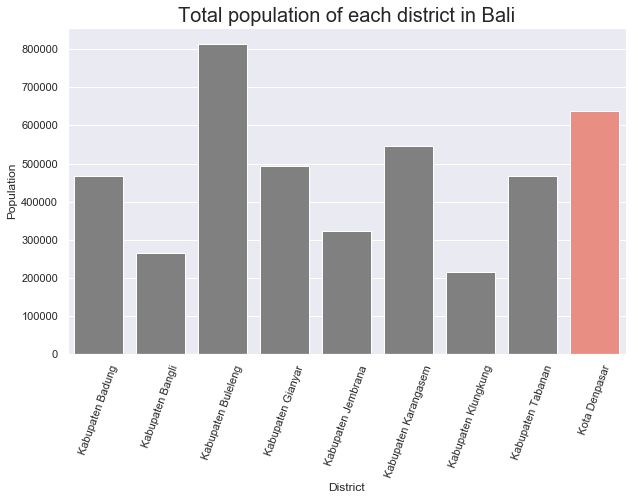

In [246]:
color = ['grey' if (x < 600000 or x > 700000) else 'salmon' for x in merged_df['Population']]

ax = sns.barplot(x="District", y="Population", data=merged_df, palette=color)
sns.set(rc={'figure.figsize':(10,6)})
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_title('Total population of each district in Bali', fontsize=20)


Based on above barplot, we will use 'Kota Denpasar':

In [247]:
focused_df = merged_df.iloc[[8], :].reset_index(drop=True)
focused_df.head()

,District,Population,Latitude,Longitude
0,Kota Denpasar,638548,-8.6705,115.2126


Define Foursquare API credential:

In [248]:
CLIENT_ID = 'DBSEJZIAXAJDY0J3H32YWG231WYT54IEEDGLBYIE1SINFIEY' # your Foursquare ID
CLIENT_SECRET = '1UWUHAE3LATTQKRUPZ5RLXCHL1SH3KGUEDHCQPNQU0COYKZI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DBSEJZIAXAJDY0J3H32YWG231WYT54IEEDGLBYIE1SINFIEY
CLIENT_SECRET:1UWUHAE3LATTQKRUPZ5RLXCHL1SH3KGUEDHCQPNQU0COYKZI


Get neighborhood information, to get lang and lat:

In [229]:
neigh_lat = focused_df.loc[0, 'Latitude'] # neighborhood latitude value
neigh_long = focused_df.loc[0, 'Longitude'] # neighborhood longitude value

neighb_name = focused_df.loc[0, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighb_name, neigh_lat, neigh_long))

Latitude and longitude values of Kabupaten Buleleng are -8.2239, 114.9517.


Get top 100 venues with radius 10 kilometers from Kota Denpasar:

In [249]:
radius=10000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neigh_lat, neigh_long, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d36aab39df1dc0023f51415'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 23,
  'suggestedBounds': {'ne': {'lat': -8.13389990999991,
    'lng': 115.04246542218648},
   'sw': {'lat': -8.313900090000091, 'lng': 114.86093457781352}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cf1d7186c29236a305f68a2',
       'name': 'Budhist Temple (Banjar Singaraja)',
       'location': {'lat': -8.210216516025788,
        'lng': 114.97424007619601,
        'labeledLatLngs': [{'label': 'display',
          'lat': -8.210216516025788,
   

Create get_category_type function:

In [250]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json and put it in dataframe:

In [251]:
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Budhist Temple (Banjar Singaraja),Park,-8.210217,114.974240
1,Villa Bossi at Banjar,Hotel,-8.183145,114.961677
2,Krisna Funtastic Land,Theme Park Ride / Attraction,-8.181188,114.994887
3,Padmasari Resort Lovina,Resort,-8.166468,115.009108
4,Krisna Wisata Kuliner,Cafeteria,-8.180946,114.994764


Info returned by Foursquare:

In [255]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

23 venues were returned by Foursquare.


<h4>4.2. Explore all venues on those 3 districts</h4>

Create function to find all venues

In [256]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call above function and create new dataframe:

In [257]:
focused_venue = getNearbyVenues(names=focused_df['District'],
                                   latitudes=focused_df['Latitude'],
                                   longitudes=focused_df['Longitude']
                                  )

Kota Denpasar


In [258]:
focused_venue.head(20)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kota Denpasar,-8.6705,115.2126,Level 21 XXI,-8.669806,115.214131,Movie Theater
1,Kota Denpasar,-8.6705,115.2126,RM Ayam Bakar Taliwang,-8.669378,115.213020,Indonesian Restaurant
2,Kota Denpasar,-8.6705,115.2126,Little Miss Cupcake,-8.669467,115.214149,Cupcake Shop
3,Kota Denpasar,-8.6705,115.2126,MM Juice,-8.669915,115.210565,Asian Restaurant
4,Kota Denpasar,-8.6705,115.2126,Depot Pempek BANGKA JAYA,-8.671424,115.213382,Chinese Restaurant
5,Kota Denpasar,-8.6705,115.2126,Wing United,-8.669552,115.214524,Wings Joint
6,Kota Denpasar,-8.6705,115.2126,Starbucks,-8.669557,115.215233,Coffee Shop
7,Kota Denpasar,-8.6705,115.2126,The Ship Billiard And Rooftop Bar,-8.670262,115.210751,Pool Hall
8,Kota Denpasar,-8.6705,115.2126,Chatime,-8.669415,115.213814,Bubble Tea Shop
9,Kota Denpasar,-8.6705,115.2126,Level 21,-8.669795,115.214672,Shopping Mall


Get dataframe shape:

In [259]:
focused_venue.shape

(53, 7)

Check how many venues for each district:

In [260]:
focused_venue.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Kota Denpasar,53,53,53,53,53,53
